In [4]:
from io import BytesIO

import boto3
from botocore import UNSIGNED
from botocore.config import Config
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.manifold import locally_linear_embedding

SEED = 42

pd.set_option("display.max_columns", None)

In [ ]:
# Read and process labels file
labels = pd.read_csv(
    "/content/drive/MyDrive/data/gz_decals_auto_posteriors_cropped.csv"
)

labels = labels[
    [
        "iauname",
        "smooth-or-featured_smooth_fraction",
        "smooth-or-featured_featured-or-disk_fraction",
        "smooth-or-featured_artifact_fraction",
    ]
]

labels.columns = ["iauname", "smooth", "featured", "artifact"]

labels["label"] = labels.values[:, 1:].argmax(axis=1)

labels.head()

,iauname,smooth,featured,artifact,label
0,J094651.40-010228.5,0.285737,0.682081,0.032182,1
1,J094630.85-004554.5,0.493212,0.455216,0.051572,0
2,J094631.59-005917.7,0.899878,0.051691,0.048431,0
3,J094744.18-004013.4,0.772967,0.099507,0.127526,0
4,J094751.74-003242.0,0.529303,0.409423,0.061275,0


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
labels["label"].value_counts()

,count
label,
0,58420
1,23904
2,962


In [7]:
filtered_labels = labels[labels["label"] != 2]

all_labels = filtered_labels["label"].unique()

IMAGES_PER_LABEL = 400

files_for_each_label = dict()

for label in all_labels:
    files_for_each_label[label] = labels[labels["label"] == label].iloc[:400]["iauname"]

In [8]:
labels = labels[
    labels["iauname"].isin(
        np.hstack([files_for_each_label[label] for label in all_labels])
    )
]
labels.shape

(800, 5)

In [ ]:
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))

bucket_name = "galaxy-morph-manifold-learning-processed"

# paginator = s3.get_paginator('list_objects_v2')
# page_iterator = paginator.paginate(Bucket=bucket_name)

# all_files = []
# for page in page_iterator:
#     if 'Contents' in page:
#         all_files.extend(page['Contents'])

# print(f"Total number of files in the bucket: {len(all_files)}")

In [ ]:
images = []

for filename in labels["iauname"].values:
    object_key = f"{filename}.png"

    response = s3.get_object(Bucket=bucket_name, Key=object_key)
    file_stream = BytesIO(response["Body"].read())

    image = Image.open(file_stream)
    image_array = np.array(image)

    images.append(image_array)

images = np.array(images)
images.shape

(800, 256, 256)

In [9]:
images = np.load("/content/drive/MyDrive/data/800_processed_images_balanced.npy")
images.shape

(800, 256, 256)

In [ ]:
np.save("/content/drive/MyDrive/data/800_processed_images_balanced.npy", images)

In [10]:
labels = pd.read_csv("/content/drive/MyDrive/data/800_processed_images_balanced.csv")
labels.head()

,iauname,smooth,featured,artifact,label
0,J094651.40-010228.5,0.285737,0.682081,0.032182,1
1,J094630.85-004554.5,0.493212,0.455216,0.051572,0
2,J094631.59-005917.7,0.899878,0.051691,0.048431,0
3,J094744.18-004013.4,0.772967,0.099507,0.127526,0
4,J094751.74-003242.0,0.529303,0.409423,0.061275,0


In [ ]:
labels.to_csv(
    "/content/drive/MyDrive/data/800_processed_images_balanced.csv", index=False
)

In [14]:
embedding, _ = locally_linear_embedding(
    images.reshape(images.shape[0], images.shape[1] * images.shape[2]),
    n_neighbors=40,
    n_components=3,
    random_state=SEED,
)
embedding.shape

(800, 3)

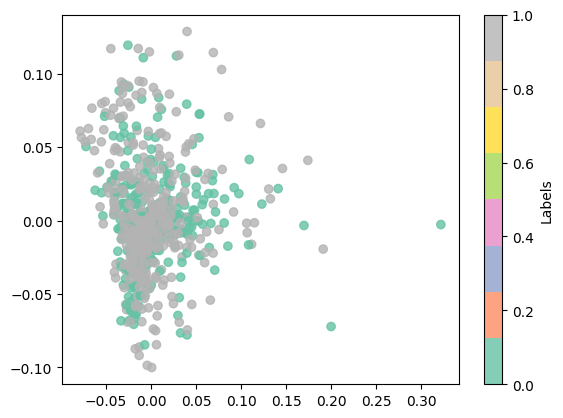

In [ ]:
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=labels["label"].values, cmap="Set2", alpha=0.8
)
plt.colorbar(label="Labels")
plt.show()

In [ ]:
fig = px.scatter_3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    color=labels["label"],
    labels={"color": "Label"},
    title="LLE",
    color_continuous_scale="viridis",
)

fig.update_layout(
    scene=dict(
        xaxis_title=f"LLE Component 1",
        yaxis_title=f"LLE Component 2",
        zaxis_title=f"LLE Component 3",
    )
)

fig.write_html(
    f"/content/drive/MyDrive/plots/LLE_3d_800_processed_images_balanced.html"
)

In [17]:
labels["label"].value_counts()

,count
label,
1,400
0,400


In [18]:
kmeans = KMeans(n_clusters=2, random_state=SEED, n_init="auto").fit(embedding)
preds = kmeans.predict(embedding)
preds.shape

(800,)

In [ ]:
fig = px.scatter_3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    color=preds,
    labels={"color": "Label"},
    title="LLE",
    color_continuous_scale="viridis",
)

fig.update_layout(
    scene=dict(
        xaxis_title=f"LLE Component 1",
        yaxis_title=f"LLE Component 2",
        zaxis_title=f"LLE Component 3",
    )
)

fig.write_html(
    f"/content/drive/MyDrive/plots/kmeans_LLE_3d_800_processed_images_balanced.html"
)